In [166]:
%matplotlib inline
import glob, re
import numpy as np
import pandas as pd
import xgboost
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [167]:
data = {
    'tra': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'as': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hs': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'ar': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hr': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'id': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'tes': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'hol': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

In [168]:
data['hr'].shape

(2000320, 4)

In [151]:
#Merge between hpg and id_
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [155]:
data['hr'].shape

(28183, 6)

In [76]:
%%time 
for df in ['ar','hr']:
    #convert to datetime + creation de "reserve_datetime_diff"

    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # Ajout de la somme (tmp1) et de la moyenne (tmp2) du nombre de visiteurs et de reserve_datetime_diff par visites    
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

CPU times: user 3.76 s, sys: 43.2 ms, total: 3.8 s
Wall time: 3.81 s


In [34]:
#convert train date into datetime
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [35]:
#convert test date into datetime
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [36]:
#Creation des unique_store dataset
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [37]:
# creation of min, mean, median, max and count visitors for every air_store_id
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

In [38]:
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
#Label encoder pour les air_genre_name and air_area_name
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [39]:
#convert date to datetime in holiday dataset
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [40]:
#creation of train and test by merging train/test and stores dataset
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 
train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

In [41]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [42]:
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [43]:
#Recuperation des id des store present dans le train
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

#Calcul de la somme, moyenne du nombre de visiteurs + moyenne du nombres de jours d'ecart entre reservation et visite au restaurant
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [44]:
# NEW FEATURES 
# 
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [45]:
# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

In [46]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [47]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [55]:
x_train.shape

(252108, 50)

In [81]:
%%time

def get_final_parameters(best_params, origin_model_d, current_model):
    """
    Fix the string parameters returned by hyperopt.

    Use the index given by hyperopt to find the real string value
    for a specific parameter
    """
    for element_p in list(best_params.keys()):
        if isinstance(
                origin_model_d[current_model][1][element_p],
                hyperopt.pyll.base.Apply):
            if origin_model_d[current_model][1][element_p].name == "float":
                pass
            elif origin_model_d[current_model][1][element_p].name == "switch":
                apply_obj = origin_model_d[current_model][1][element_p]
                literal_obj = apply_obj.pos_args[best_params[element_p] + 1]
                best_params[element_p] = literal_obj.obj
            else:
                pass
        else:
            pass
    return best_params

def regression_params_opt(
        origin_model_d,
        current_model,
        x_train,
        x_test,
        y_train,
        y_test):
    print(current_model)
    best = 0
    global i
    i = 0
    max_eval = 100
    trials = Trials()

    def rmse_score(params):
        global i
        print("origin_model_d[current_model]",origin_model_d[current_model][0](**params))
        v = np.array(range(x_train.shape[0]))%2==0
        #v = [e%2==0 for e in range(x_train.shape[0]]
        model_fit = origin_model_d[current_model][0](
            **params).fit(x_train[v], y_train[v],eval_set=[(x_train[v],y_train[v]),(x_train[v==False],y_train[v==False]),],early_stopping_rounds=50)
        y_pred_train = model_fit.predict(x_test)
        loss = mean_squared_error(y_test, y_pred_train)**0.5
        df_result_hyperopt.loc[i] = np.append(loss, list(params.values()))
        i = i + 1
        return {'loss': loss, 'status': STATUS_OK}

    df_result_hyperopt = pd.DataFrame(
        columns=[
            np.append(
                'score', list(
                    origin_model_d[current_model][1].keys()))])

    best = fmin(rmse_score,
                origin_model_d[current_model][1],
                algo=tpe.suggest,
                max_evals=max_eval,
                trials=trials)
    print(best)
    print(best.keys())
    print("\n")
    return get_final_parameters(best, origin_model_d, current_model)

if __name__ == '__main__':

    xgbr_d = {'gamma': hp.quniform('gamma', 0.0, 5.0, 0.1),
              'learning_rate': hp.choice('learning_rate', [0.1]),
              'colsample_bytree': hp.quniform('colsample_bytree',
                                              0.3,
                                              1.,
                                              0.05),
              'max_depth': hp.choice('max_depth', list(range(3, 12))),
              'min_child_weight': hp.quniform('min_child_weight', 1., 5., 1),
              'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
              'nthread': hp.choice('nthread', [8,]),
              'n_jobs': hp.choice('n_jobs', [8,]),
              'n_estimators': hp.choice('n_estimators', [10000]),
              'objective': hp.choice('objective', ['reg:linear']),
              'reg_lambda': hp.quniform('reg_alpha', 0.0, 4.0, 0.1),
              'reg_alpha': hp.quniform('reg_lambda', 0.0, 4.0, 0.1)}

    base_model = {"XGBRegressor": [XGBRegressor, xgbr_d]}


    x_train = train[col]
    y_train = train["visitors"]

    x_test = test[col]
    y_test = test["visitors"]

    hyper_parametres = regression_params_opt(
        origin_model_d=base_model,
        current_model="XGBRegressor",
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test
    )

df_result_hyperopt = pd.DataFrame(columns=[np.append('score', list(space4rf.keys()))])

XGBRegressor
origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6000000000000001, gamma=4.9, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=3.0, missing=None,
       n_estimators=10000, n_jobs=8, nthread=8, objective='reg:linear',
       random_state=0, reg_alpha=0.30000000000000004,
       reg_lambda=3.3000000000000003, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7000000000000001)
[0]	validation_0-rmse:24.3315	validation_1-rmse:24.2547
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.4189	validation_1-rmse:22.3546
[2]	validation_0-rmse:20.7346	validation_1-rmse:20.6781
[3]	validation_0-rmse:19.2603	validation_1-rmse:19.2137
[4]	validation_0-rmse:17.9772	validation_1-rmse:17.9462
[5]	validation_0-rmse:16.8561	validation_1-rmse:16.8424


[133]	validation_0-rmse:9.01849	validation_1-rmse:10.5127
[134]	validation_0-rmse:9.01682	validation_1-rmse:10.5141
[135]	validation_0-rmse:9.00364	validation_1-rmse:10.5112
[136]	validation_0-rmse:9.00201	validation_1-rmse:10.515
[137]	validation_0-rmse:9.00016	validation_1-rmse:10.5174
[138]	validation_0-rmse:8.99745	validation_1-rmse:10.5159
[139]	validation_0-rmse:8.98864	validation_1-rmse:10.5211
[140]	validation_0-rmse:8.98247	validation_1-rmse:10.5194
[141]	validation_0-rmse:8.97475	validation_1-rmse:10.5217
[142]	validation_0-rmse:8.96801	validation_1-rmse:10.5234
[143]	validation_0-rmse:8.95671	validation_1-rmse:10.5278
[144]	validation_0-rmse:8.95623	validation_1-rmse:10.5305
[145]	validation_0-rmse:8.95173	validation_1-rmse:10.5284
[146]	validation_0-rmse:8.94616	validation_1-rmse:10.5276
[147]	validation_0-rmse:8.94265	validation_1-rmse:10.5263
[148]	validation_0-rmse:8.9384	validation_1-rmse:10.5274
[149]	validation_0-rmse:8.93463	validation_1-rmse:10.5286
[150]	validation

[94]	validation_0-rmse:9.57734	validation_1-rmse:10.5853
[95]	validation_0-rmse:9.57117	validation_1-rmse:10.5864
[96]	validation_0-rmse:9.5666	validation_1-rmse:10.5859
[97]	validation_0-rmse:9.5598	validation_1-rmse:10.5828
[98]	validation_0-rmse:9.55379	validation_1-rmse:10.5811
[99]	validation_0-rmse:9.5477	validation_1-rmse:10.5855
[100]	validation_0-rmse:9.54586	validation_1-rmse:10.5856
[101]	validation_0-rmse:9.54142	validation_1-rmse:10.589
[102]	validation_0-rmse:9.53829	validation_1-rmse:10.5883
[103]	validation_0-rmse:9.53508	validation_1-rmse:10.5909
[104]	validation_0-rmse:9.52537	validation_1-rmse:10.5953
[105]	validation_0-rmse:9.52114	validation_1-rmse:10.5953
[106]	validation_0-rmse:9.51463	validation_1-rmse:10.5925
[107]	validation_0-rmse:9.5107	validation_1-rmse:10.5928
[108]	validation_0-rmse:9.49484	validation_1-rmse:10.5905
[109]	validation_0-rmse:9.48748	validation_1-rmse:10.5935
[110]	validation_0-rmse:9.47809	validation_1-rmse:10.5911
Stopping. Best iteration:

Stopping. Best iteration:
[64]	validation_0-rmse:8.69942	validation_1-rmse:10.5374

origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, gamma=3.8000000000000003, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=3.0, missing=None,
       n_estimators=10000, n_jobs=8, nthread=8, objective='reg:linear',
       random_state=0, reg_alpha=2.2, reg_lambda=2.5, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75)
[0]	validation_0-rmse:24.3292	validation_1-rmse:24.249
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.4208	validation_1-rmse:22.342
[2]	validation_0-rmse:20.7409	validation_1-rmse:20.6651
[3]	validation_0-rmse:19.2753	validation_1-rmse:19.2024
[4]	validation_0-rmse:17.9989	validation_1-rmse:17.9279
[5]	validation_0-rmse:16.8877	validatio

[132]	validation_0-rmse:9.75895	validation_1-rmse:10.6039
[133]	validation_0-rmse:9.75317	validation_1-rmse:10.605
[134]	validation_0-rmse:9.75242	validation_1-rmse:10.6059
[135]	validation_0-rmse:9.74668	validation_1-rmse:10.6047
[136]	validation_0-rmse:9.74445	validation_1-rmse:10.6084
[137]	validation_0-rmse:9.74388	validation_1-rmse:10.6102
[138]	validation_0-rmse:9.73968	validation_1-rmse:10.6055
[139]	validation_0-rmse:9.73407	validation_1-rmse:10.6043
[140]	validation_0-rmse:9.73144	validation_1-rmse:10.6019
[141]	validation_0-rmse:9.72489	validation_1-rmse:10.6032
[142]	validation_0-rmse:9.7211	validation_1-rmse:10.6048
[143]	validation_0-rmse:9.71533	validation_1-rmse:10.6075
[144]	validation_0-rmse:9.71561	validation_1-rmse:10.611
[145]	validation_0-rmse:9.71501	validation_1-rmse:10.6111
[146]	validation_0-rmse:9.70727	validation_1-rmse:10.6106
[147]	validation_0-rmse:9.7056	validation_1-rmse:10.6073
[148]	validation_0-rmse:9.70163	validation_1-rmse:10.6068
[149]	validation_0

[94]	validation_0-rmse:10.6419	validation_1-rmse:10.7344
[95]	validation_0-rmse:10.6401	validation_1-rmse:10.7329
[96]	validation_0-rmse:10.6389	validation_1-rmse:10.7328
[97]	validation_0-rmse:10.6381	validation_1-rmse:10.7322
[98]	validation_0-rmse:10.6361	validation_1-rmse:10.7305
[99]	validation_0-rmse:10.6346	validation_1-rmse:10.7329
[100]	validation_0-rmse:10.6325	validation_1-rmse:10.7313
[101]	validation_0-rmse:10.6316	validation_1-rmse:10.7332
[102]	validation_0-rmse:10.6302	validation_1-rmse:10.7346
[103]	validation_0-rmse:10.6294	validation_1-rmse:10.7342
[104]	validation_0-rmse:10.6262	validation_1-rmse:10.7363
[105]	validation_0-rmse:10.6249	validation_1-rmse:10.7355
[106]	validation_0-rmse:10.6235	validation_1-rmse:10.7341
[107]	validation_0-rmse:10.6217	validation_1-rmse:10.7328
[108]	validation_0-rmse:10.6201	validation_1-rmse:10.7348
[109]	validation_0-rmse:10.6197	validation_1-rmse:10.7322
[110]	validation_0-rmse:10.618	validation_1-rmse:10.7305
[111]	validation_0-rm

[55]	validation_0-rmse:9.59798	validation_1-rmse:10.5147
[56]	validation_0-rmse:9.59118	validation_1-rmse:10.5136
[57]	validation_0-rmse:9.57164	validation_1-rmse:10.5091
[58]	validation_0-rmse:9.54609	validation_1-rmse:10.5011
[59]	validation_0-rmse:9.54002	validation_1-rmse:10.4992
[60]	validation_0-rmse:9.51937	validation_1-rmse:10.4995
[61]	validation_0-rmse:9.50932	validation_1-rmse:10.4986
[62]	validation_0-rmse:9.48918	validation_1-rmse:10.4921
[63]	validation_0-rmse:9.48554	validation_1-rmse:10.492
[64]	validation_0-rmse:9.46593	validation_1-rmse:10.4862
[65]	validation_0-rmse:9.45314	validation_1-rmse:10.4878
[66]	validation_0-rmse:9.44634	validation_1-rmse:10.4887
[67]	validation_0-rmse:9.43026	validation_1-rmse:10.492
[68]	validation_0-rmse:9.41598	validation_1-rmse:10.4929
[69]	validation_0-rmse:9.4002	validation_1-rmse:10.4889
[70]	validation_0-rmse:9.38311	validation_1-rmse:10.4858
[71]	validation_0-rmse:9.38144	validation_1-rmse:10.4869
[72]	validation_0-rmse:9.37009	val

[46]	validation_0-rmse:9.90745	validation_1-rmse:10.5905
[47]	validation_0-rmse:9.90036	validation_1-rmse:10.5841
[48]	validation_0-rmse:9.89316	validation_1-rmse:10.5834
[49]	validation_0-rmse:9.8792	validation_1-rmse:10.578
[50]	validation_0-rmse:9.86458	validation_1-rmse:10.5765
[51]	validation_0-rmse:9.85509	validation_1-rmse:10.5766
[52]	validation_0-rmse:9.84783	validation_1-rmse:10.5734
[53]	validation_0-rmse:9.8375	validation_1-rmse:10.5712
[54]	validation_0-rmse:9.83174	validation_1-rmse:10.5709
[55]	validation_0-rmse:9.82496	validation_1-rmse:10.574
[56]	validation_0-rmse:9.81681	validation_1-rmse:10.5718
[57]	validation_0-rmse:9.81548	validation_1-rmse:10.568
[58]	validation_0-rmse:9.79572	validation_1-rmse:10.5682
[59]	validation_0-rmse:9.78733	validation_1-rmse:10.57
[60]	validation_0-rmse:9.76884	validation_1-rmse:10.5679
[61]	validation_0-rmse:9.75432	validation_1-rmse:10.5717
[62]	validation_0-rmse:9.74965	validation_1-rmse:10.57
[63]	validation_0-rmse:9.74401	validatio

[52]	validation_0-rmse:10.4245	validation_1-rmse:10.7232
[53]	validation_0-rmse:10.42	validation_1-rmse:10.7204
[54]	validation_0-rmse:10.4165	validation_1-rmse:10.718
[55]	validation_0-rmse:10.4026	validation_1-rmse:10.7219
[56]	validation_0-rmse:10.3932	validation_1-rmse:10.7185
[57]	validation_0-rmse:10.3834	validation_1-rmse:10.7175
[58]	validation_0-rmse:10.366	validation_1-rmse:10.7203
[59]	validation_0-rmse:10.3542	validation_1-rmse:10.7251
[60]	validation_0-rmse:10.3426	validation_1-rmse:10.7238
[61]	validation_0-rmse:10.3302	validation_1-rmse:10.7288
[62]	validation_0-rmse:10.3293	validation_1-rmse:10.7271
[63]	validation_0-rmse:10.3227	validation_1-rmse:10.726
[64]	validation_0-rmse:10.3126	validation_1-rmse:10.7305
[65]	validation_0-rmse:10.3017	validation_1-rmse:10.7338
[66]	validation_0-rmse:10.2977	validation_1-rmse:10.7312
[67]	validation_0-rmse:10.2889	validation_1-rmse:10.7304
[68]	validation_0-rmse:10.2807	validation_1-rmse:10.7362
[69]	validation_0-rmse:10.2721	valid

[77]	validation_0-rmse:10.2757	validation_1-rmse:10.6266
[78]	validation_0-rmse:10.2695	validation_1-rmse:10.6273
[79]	validation_0-rmse:10.2666	validation_1-rmse:10.6266
[80]	validation_0-rmse:10.2503	validation_1-rmse:10.6273
[81]	validation_0-rmse:10.2355	validation_1-rmse:10.6294
[82]	validation_0-rmse:10.2236	validation_1-rmse:10.6278
[83]	validation_0-rmse:10.2077	validation_1-rmse:10.6329
[84]	validation_0-rmse:10.1929	validation_1-rmse:10.638
[85]	validation_0-rmse:10.1887	validation_1-rmse:10.6422
[86]	validation_0-rmse:10.1758	validation_1-rmse:10.6472
[87]	validation_0-rmse:10.1656	validation_1-rmse:10.6525
[88]	validation_0-rmse:10.154	validation_1-rmse:10.656
[89]	validation_0-rmse:10.1457	validation_1-rmse:10.6625
[90]	validation_0-rmse:10.1358	validation_1-rmse:10.6673
[91]	validation_0-rmse:10.127	validation_1-rmse:10.6734
[92]	validation_0-rmse:10.1244	validation_1-rmse:10.6762
[93]	validation_0-rmse:10.1155	validation_1-rmse:10.6811
[94]	validation_0-rmse:10.1075	vali

[85]	validation_0-rmse:9.63192	validation_1-rmse:10.5097
[86]	validation_0-rmse:9.61347	validation_1-rmse:10.5072
[87]	validation_0-rmse:9.60933	validation_1-rmse:10.5081
[88]	validation_0-rmse:9.60635	validation_1-rmse:10.5074
[89]	validation_0-rmse:9.60359	validation_1-rmse:10.5072
[90]	validation_0-rmse:9.5884	validation_1-rmse:10.5051
[91]	validation_0-rmse:9.57145	validation_1-rmse:10.5045
[92]	validation_0-rmse:9.57083	validation_1-rmse:10.5042
[93]	validation_0-rmse:9.56877	validation_1-rmse:10.5062
[94]	validation_0-rmse:9.55469	validation_1-rmse:10.5039
[95]	validation_0-rmse:9.55132	validation_1-rmse:10.5033
[96]	validation_0-rmse:9.54652	validation_1-rmse:10.5032
[97]	validation_0-rmse:9.5332	validation_1-rmse:10.5034
[98]	validation_0-rmse:9.52525	validation_1-rmse:10.5018
[99]	validation_0-rmse:9.51989	validation_1-rmse:10.5036
[100]	validation_0-rmse:9.51669	validation_1-rmse:10.503
[101]	validation_0-rmse:9.51186	validation_1-rmse:10.5041
[102]	validation_0-rmse:9.49624	

[0]	validation_0-rmse:24.3703	validation_1-rmse:24.2868
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.4915	validation_1-rmse:22.4027
[2]	validation_0-rmse:20.8406	validation_1-rmse:20.7475
[3]	validation_0-rmse:19.5275	validation_1-rmse:19.4306
[4]	validation_0-rmse:18.4055	validation_1-rmse:18.3028
[5]	validation_0-rmse:17.2975	validation_1-rmse:17.1889
[6]	validation_0-rmse:16.5544	validation_1-rmse:16.4454
[7]	validation_0-rmse:15.8061	validation_1-rmse:15.6945
[8]	validation_0-rmse:15.294	validation_1-rmse:15.1807
[9]	validation_0-rmse:14.8678	validation_1-rmse:14.7519
[10]	validation_0-rmse:14.2558	validation_1-rmse:14.1363
[11]	validation_0-rmse:13.7405	validation_1-rmse:13.6178
[12]	validation_0-rmse:13.3016	validation_1-rmse:13.1759
[13]	validation_0-rmse:12.9259	validation_1-rmse:12.7981
[14]	validation_0-rmse:12.6742	validation_1-rmse:12.54

[141]	validation_0-rmse:10.641	validation_1-rmse:10.7505
[142]	validation_0-rmse:10.6398	validation_1-rmse:10.7498
[143]	validation_0-rmse:10.6384	validation_1-rmse:10.7491
[144]	validation_0-rmse:10.634	validation_1-rmse:10.7675
[145]	validation_0-rmse:10.6338	validation_1-rmse:10.7663
[146]	validation_0-rmse:10.6332	validation_1-rmse:10.7658
[147]	validation_0-rmse:10.6331	validation_1-rmse:10.7647
[148]	validation_0-rmse:10.6323	validation_1-rmse:10.7647
[149]	validation_0-rmse:10.6311	validation_1-rmse:10.7636
[150]	validation_0-rmse:10.6306	validation_1-rmse:10.7658
[151]	validation_0-rmse:10.6265	validation_1-rmse:10.7636
[152]	validation_0-rmse:10.6238	validation_1-rmse:10.7635
[153]	validation_0-rmse:10.6226	validation_1-rmse:10.7629
[154]	validation_0-rmse:10.6212	validation_1-rmse:10.7615
[155]	validation_0-rmse:10.6196	validation_1-rmse:10.7607
[156]	validation_0-rmse:10.6158	validation_1-rmse:10.7611
[157]	validation_0-rmse:10.6148	validation_1-rmse:10.7601
[158]	validation

[88]	validation_0-rmse:9.8367	validation_1-rmse:10.5211
[89]	validation_0-rmse:9.83231	validation_1-rmse:10.5199
[90]	validation_0-rmse:9.82316	validation_1-rmse:10.5178
[91]	validation_0-rmse:9.81917	validation_1-rmse:10.52
[92]	validation_0-rmse:9.81487	validation_1-rmse:10.5213
[93]	validation_0-rmse:9.81296	validation_1-rmse:10.5237
[94]	validation_0-rmse:9.80461	validation_1-rmse:10.5224
[95]	validation_0-rmse:9.79711	validation_1-rmse:10.5226
[96]	validation_0-rmse:9.79402	validation_1-rmse:10.5234
[97]	validation_0-rmse:9.79112	validation_1-rmse:10.5237
[98]	validation_0-rmse:9.78618	validation_1-rmse:10.5214
[99]	validation_0-rmse:9.77937	validation_1-rmse:10.5223
[100]	validation_0-rmse:9.7777	validation_1-rmse:10.5228
[101]	validation_0-rmse:9.77373	validation_1-rmse:10.523
[102]	validation_0-rmse:9.76816	validation_1-rmse:10.524
[103]	validation_0-rmse:9.76705	validation_1-rmse:10.5245
[104]	validation_0-rmse:9.76573	validation_1-rmse:10.5273
[105]	validation_0-rmse:9.75897	

[46]	validation_0-rmse:10.8552	validation_1-rmse:10.7958
[47]	validation_0-rmse:10.849	validation_1-rmse:10.7915
[48]	validation_0-rmse:10.8428	validation_1-rmse:10.7856
[49]	validation_0-rmse:10.8373	validation_1-rmse:10.7836
[50]	validation_0-rmse:10.83	validation_1-rmse:10.7773
[51]	validation_0-rmse:10.825	validation_1-rmse:10.7729
[52]	validation_0-rmse:10.8182	validation_1-rmse:10.7672
[53]	validation_0-rmse:10.8128	validation_1-rmse:10.7627
[54]	validation_0-rmse:10.8098	validation_1-rmse:10.7607
[55]	validation_0-rmse:10.8039	validation_1-rmse:10.7583
[56]	validation_0-rmse:10.7989	validation_1-rmse:10.7553
[57]	validation_0-rmse:10.7932	validation_1-rmse:10.751
[58]	validation_0-rmse:10.7873	validation_1-rmse:10.748
[59]	validation_0-rmse:10.7841	validation_1-rmse:10.7456
[60]	validation_0-rmse:10.7741	validation_1-rmse:10.7449
[61]	validation_0-rmse:10.7708	validation_1-rmse:10.7423
[62]	validation_0-rmse:10.7663	validation_1-rmse:10.7389
[63]	validation_0-rmse:10.7635	valida

[0]	validation_0-rmse:24.3223	validation_1-rmse:24.2423
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.4041	validation_1-rmse:22.3261
[2]	validation_0-rmse:20.7149	validation_1-rmse:20.6405
[3]	validation_0-rmse:19.2417	validation_1-rmse:19.1695
[4]	validation_0-rmse:17.9613	validation_1-rmse:17.8913
[5]	validation_0-rmse:16.8486	validation_1-rmse:16.7785
[6]	validation_0-rmse:15.8791	validation_1-rmse:15.8186
[7]	validation_0-rmse:15.0529	validation_1-rmse:14.9954
[8]	validation_0-rmse:14.3483	validation_1-rmse:14.2965
[9]	validation_0-rmse:13.744	validation_1-rmse:13.6977
[10]	validation_0-rmse:13.234	validation_1-rmse:13.191
[11]	validation_0-rmse:12.805	validation_1-rmse:12.7673
[12]	validation_0-rmse:12.4436	validation_1-rmse:12.4099
[13]	validation_0-rmse:12.1444	validation_1-rmse:12.1135
[14]	validation_0-rmse:11.8912	validation_1-rmse:11.8659


[36]	validation_0-rmse:9.76932	validation_1-rmse:10.6022
[37]	validation_0-rmse:9.75131	validation_1-rmse:10.5987
[38]	validation_0-rmse:9.72249	validation_1-rmse:10.5975
[39]	validation_0-rmse:9.71053	validation_1-rmse:10.5916
[40]	validation_0-rmse:9.6997	validation_1-rmse:10.5923
[41]	validation_0-rmse:9.68771	validation_1-rmse:10.588
[42]	validation_0-rmse:9.65986	validation_1-rmse:10.5831
[43]	validation_0-rmse:9.64833	validation_1-rmse:10.5772
[44]	validation_0-rmse:9.62957	validation_1-rmse:10.5738
[45]	validation_0-rmse:9.60886	validation_1-rmse:10.5775
[46]	validation_0-rmse:9.58733	validation_1-rmse:10.5746
[47]	validation_0-rmse:9.58246	validation_1-rmse:10.5726
[48]	validation_0-rmse:9.57758	validation_1-rmse:10.5713
[49]	validation_0-rmse:9.56457	validation_1-rmse:10.5693
[50]	validation_0-rmse:9.55291	validation_1-rmse:10.5725
[51]	validation_0-rmse:9.54132	validation_1-rmse:10.5716
[52]	validation_0-rmse:9.53432	validation_1-rmse:10.568
[53]	validation_0-rmse:9.51196	val

[54]	validation_0-rmse:10.5397	validation_1-rmse:10.6842
[55]	validation_0-rmse:10.5298	validation_1-rmse:10.6839
[56]	validation_0-rmse:10.5259	validation_1-rmse:10.6812
[57]	validation_0-rmse:10.5239	validation_1-rmse:10.6771
[58]	validation_0-rmse:10.5169	validation_1-rmse:10.6728
[59]	validation_0-rmse:10.5111	validation_1-rmse:10.6699
[60]	validation_0-rmse:10.5064	validation_1-rmse:10.6706
[61]	validation_0-rmse:10.5035	validation_1-rmse:10.6701
[62]	validation_0-rmse:10.4988	validation_1-rmse:10.6668
[63]	validation_0-rmse:10.4928	validation_1-rmse:10.6694
[64]	validation_0-rmse:10.4892	validation_1-rmse:10.6675
[65]	validation_0-rmse:10.4794	validation_1-rmse:10.6654
[66]	validation_0-rmse:10.4789	validation_1-rmse:10.6625
[67]	validation_0-rmse:10.4792	validation_1-rmse:10.658
[68]	validation_0-rmse:10.4713	validation_1-rmse:10.6581
[69]	validation_0-rmse:10.4681	validation_1-rmse:10.6555
[70]	validation_0-rmse:10.4635	validation_1-rmse:10.6544
[71]	validation_0-rmse:10.4623	v

[53]	validation_0-rmse:9.39897	validation_1-rmse:10.54
[54]	validation_0-rmse:9.38919	validation_1-rmse:10.5368
[55]	validation_0-rmse:9.36858	validation_1-rmse:10.5357
[56]	validation_0-rmse:9.35731	validation_1-rmse:10.5369
[57]	validation_0-rmse:9.34952	validation_1-rmse:10.532
[58]	validation_0-rmse:9.32752	validation_1-rmse:10.5293
[59]	validation_0-rmse:9.31585	validation_1-rmse:10.5309
[60]	validation_0-rmse:9.30619	validation_1-rmse:10.5341
[61]	validation_0-rmse:9.29577	validation_1-rmse:10.533
[62]	validation_0-rmse:9.28467	validation_1-rmse:10.5312
[63]	validation_0-rmse:9.26891	validation_1-rmse:10.5336
[64]	validation_0-rmse:9.26066	validation_1-rmse:10.5363
[65]	validation_0-rmse:9.24665	validation_1-rmse:10.5337
[66]	validation_0-rmse:9.23574	validation_1-rmse:10.5347
[67]	validation_0-rmse:9.22592	validation_1-rmse:10.5346
[68]	validation_0-rmse:9.21988	validation_1-rmse:10.5342
[69]	validation_0-rmse:9.20774	validation_1-rmse:10.5358
[70]	validation_0-rmse:9.20393	vali

[76]	validation_0-rmse:9.60057	validation_1-rmse:10.535
[77]	validation_0-rmse:9.59623	validation_1-rmse:10.5335
[78]	validation_0-rmse:9.58998	validation_1-rmse:10.5316
[79]	validation_0-rmse:9.57973	validation_1-rmse:10.5323
[80]	validation_0-rmse:9.56266	validation_1-rmse:10.5287
[81]	validation_0-rmse:9.54364	validation_1-rmse:10.5295
[82]	validation_0-rmse:9.53825	validation_1-rmse:10.5343
[83]	validation_0-rmse:9.53308	validation_1-rmse:10.5325
[84]	validation_0-rmse:9.53211	validation_1-rmse:10.5334
[85]	validation_0-rmse:9.51731	validation_1-rmse:10.5343
[86]	validation_0-rmse:9.51173	validation_1-rmse:10.5338
[87]	validation_0-rmse:9.51065	validation_1-rmse:10.534
[88]	validation_0-rmse:9.50621	validation_1-rmse:10.5331
[89]	validation_0-rmse:9.50131	validation_1-rmse:10.5362
[90]	validation_0-rmse:9.48711	validation_1-rmse:10.5349
[91]	validation_0-rmse:9.48487	validation_1-rmse:10.5366
[92]	validation_0-rmse:9.47945	validation_1-rmse:10.5377
[93]	validation_0-rmse:9.47782	va

[77]	validation_0-rmse:9.93597	validation_1-rmse:10.6081
[78]	validation_0-rmse:9.92079	validation_1-rmse:10.6127
[79]	validation_0-rmse:9.90232	validation_1-rmse:10.614
[80]	validation_0-rmse:9.90101	validation_1-rmse:10.6138
[81]	validation_0-rmse:9.89447	validation_1-rmse:10.6133
[82]	validation_0-rmse:9.89324	validation_1-rmse:10.6136
[83]	validation_0-rmse:9.88596	validation_1-rmse:10.6107
[84]	validation_0-rmse:9.88457	validation_1-rmse:10.6115
[85]	validation_0-rmse:9.88432	validation_1-rmse:10.6115
[86]	validation_0-rmse:9.87563	validation_1-rmse:10.6137
[87]	validation_0-rmse:9.87335	validation_1-rmse:10.6136
[88]	validation_0-rmse:9.86717	validation_1-rmse:10.6116
[89]	validation_0-rmse:9.86556	validation_1-rmse:10.6118
[90]	validation_0-rmse:9.85258	validation_1-rmse:10.6116
[91]	validation_0-rmse:9.84767	validation_1-rmse:10.6128
[92]	validation_0-rmse:9.84767	validation_1-rmse:10.6128
[93]	validation_0-rmse:9.84353	validation_1-rmse:10.6155
[94]	validation_0-rmse:9.82753	v

[95]	validation_0-rmse:10.5671	validation_1-rmse:10.6699
[96]	validation_0-rmse:10.566	validation_1-rmse:10.6694
[97]	validation_0-rmse:10.5644	validation_1-rmse:10.6687
[98]	validation_0-rmse:10.5632	validation_1-rmse:10.6684
[99]	validation_0-rmse:10.5579	validation_1-rmse:10.6704
[100]	validation_0-rmse:10.5569	validation_1-rmse:10.6704
[101]	validation_0-rmse:10.5547	validation_1-rmse:10.6695
[102]	validation_0-rmse:10.5533	validation_1-rmse:10.671
[103]	validation_0-rmse:10.5502	validation_1-rmse:10.6739
[104]	validation_0-rmse:10.5481	validation_1-rmse:10.6739
[105]	validation_0-rmse:10.547	validation_1-rmse:10.6732
[106]	validation_0-rmse:10.5398	validation_1-rmse:10.6769
[107]	validation_0-rmse:10.5391	validation_1-rmse:10.6779
[108]	validation_0-rmse:10.5368	validation_1-rmse:10.6773
[109]	validation_0-rmse:10.5335	validation_1-rmse:10.6755
[110]	validation_0-rmse:10.5306	validation_1-rmse:10.6733
[111]	validation_0-rmse:10.5288	validation_1-rmse:10.673
[112]	validation_0-rmse

[89]	validation_0-rmse:10.7221	validation_1-rmse:10.733
[90]	validation_0-rmse:10.7181	validation_1-rmse:10.7344
[91]	validation_0-rmse:10.7159	validation_1-rmse:10.7333
[92]	validation_0-rmse:10.6955	validation_1-rmse:10.7335
[93]	validation_0-rmse:10.6938	validation_1-rmse:10.7344
[94]	validation_0-rmse:10.6921	validation_1-rmse:10.734
[95]	validation_0-rmse:10.6908	validation_1-rmse:10.7332
[96]	validation_0-rmse:10.6899	validation_1-rmse:10.7332
[97]	validation_0-rmse:10.6893	validation_1-rmse:10.7327
[98]	validation_0-rmse:10.6876	validation_1-rmse:10.7313
[99]	validation_0-rmse:10.6859	validation_1-rmse:10.7331
[100]	validation_0-rmse:10.6851	validation_1-rmse:10.733
[101]	validation_0-rmse:10.6845	validation_1-rmse:10.7357
[102]	validation_0-rmse:10.6838	validation_1-rmse:10.7369
[103]	validation_0-rmse:10.6831	validation_1-rmse:10.7365
[104]	validation_0-rmse:10.679	validation_1-rmse:10.7409
[105]	validation_0-rmse:10.677	validation_1-rmse:10.7392
[106]	validation_0-rmse:10.675

[40]	validation_0-rmse:10.9508	validation_1-rmse:10.8335
[41]	validation_0-rmse:10.9441	validation_1-rmse:10.8274
[42]	validation_0-rmse:10.9407	validation_1-rmse:10.8236
[43]	validation_0-rmse:10.9363	validation_1-rmse:10.8202
[44]	validation_0-rmse:10.9304	validation_1-rmse:10.8155
[45]	validation_0-rmse:10.9212	validation_1-rmse:10.8077
[46]	validation_0-rmse:10.9164	validation_1-rmse:10.8034
[47]	validation_0-rmse:10.9124	validation_1-rmse:10.801
[48]	validation_0-rmse:10.9081	validation_1-rmse:10.798
[49]	validation_0-rmse:10.9023	validation_1-rmse:10.7936
[50]	validation_0-rmse:10.8988	validation_1-rmse:10.7901
[51]	validation_0-rmse:10.8966	validation_1-rmse:10.7884
[52]	validation_0-rmse:10.8934	validation_1-rmse:10.786
[53]	validation_0-rmse:10.8896	validation_1-rmse:10.7825
[54]	validation_0-rmse:10.8867	validation_1-rmse:10.7803
[55]	validation_0-rmse:10.8802	validation_1-rmse:10.7765
[56]	validation_0-rmse:10.8771	validation_1-rmse:10.7743
[57]	validation_0-rmse:10.8718	val

[183]	validation_0-rmse:10.6304	validation_1-rmse:10.7318
[184]	validation_0-rmse:10.6293	validation_1-rmse:10.7321
Stopping. Best iteration:
[134]	validation_0-rmse:10.705	validation_1-rmse:10.7246

origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=10000, n_jobs=8, nthread=8, objective='reg:linear',
       random_state=0, reg_alpha=3.8000000000000003, reg_lambda=0.9,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6000000000000001)
[0]	validation_0-rmse:24.3705	validation_1-rmse:24.287
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.4919	validation_1-rmse:22.4031
[2]	validation_0-rmse:20.8411	validation_1-rmse:20.748
[3]	validation_

[130]	validation_0-rmse:10.6067	validation_1-rmse:10.7176
[131]	validation_0-rmse:10.6065	validation_1-rmse:10.7175
[132]	validation_0-rmse:10.6011	validation_1-rmse:10.7185
[133]	validation_0-rmse:10.5994	validation_1-rmse:10.7166
[134]	validation_0-rmse:10.5985	validation_1-rmse:10.7171
[135]	validation_0-rmse:10.5836	validation_1-rmse:10.7242
[136]	validation_0-rmse:10.5819	validation_1-rmse:10.7245
[137]	validation_0-rmse:10.5815	validation_1-rmse:10.7273
[138]	validation_0-rmse:10.5806	validation_1-rmse:10.7269
[139]	validation_0-rmse:10.5723	validation_1-rmse:10.7266
[140]	validation_0-rmse:10.572	validation_1-rmse:10.7248
[141]	validation_0-rmse:10.565	validation_1-rmse:10.7238
[142]	validation_0-rmse:10.5643	validation_1-rmse:10.7239
[143]	validation_0-rmse:10.5548	validation_1-rmse:10.7321
[144]	validation_0-rmse:10.5515	validation_1-rmse:10.743
[145]	validation_0-rmse:10.5512	validation_1-rmse:10.7419
[146]	validation_0-rmse:10.5501	validation_1-rmse:10.7424
[147]	validation_

[78]	validation_0-rmse:10.7727	validation_1-rmse:10.7421
[79]	validation_0-rmse:10.7651	validation_1-rmse:10.744
[80]	validation_0-rmse:10.7634	validation_1-rmse:10.7433
[81]	validation_0-rmse:10.7617	validation_1-rmse:10.7425
[82]	validation_0-rmse:10.7596	validation_1-rmse:10.7405
[83]	validation_0-rmse:10.7578	validation_1-rmse:10.7401
[84]	validation_0-rmse:10.7574	validation_1-rmse:10.7407
[85]	validation_0-rmse:10.7548	validation_1-rmse:10.7386
[86]	validation_0-rmse:10.7541	validation_1-rmse:10.7378
[87]	validation_0-rmse:10.7537	validation_1-rmse:10.7384
[88]	validation_0-rmse:10.7506	validation_1-rmse:10.7367
[89]	validation_0-rmse:10.7491	validation_1-rmse:10.7365
[90]	validation_0-rmse:10.7415	validation_1-rmse:10.7366
[91]	validation_0-rmse:10.7328	validation_1-rmse:10.74
[92]	validation_0-rmse:10.7304	validation_1-rmse:10.738
[93]	validation_0-rmse:10.7296	validation_1-rmse:10.7402
[94]	validation_0-rmse:10.7181	validation_1-rmse:10.744
[95]	validation_0-rmse:10.7166	valid

[29]	validation_0-rmse:11.0792	validation_1-rmse:10.9432
[30]	validation_0-rmse:11.0595	validation_1-rmse:10.9234
[31]	validation_0-rmse:11.0454	validation_1-rmse:10.9111
[32]	validation_0-rmse:11.0295	validation_1-rmse:10.9034
[33]	validation_0-rmse:11.014	validation_1-rmse:10.889
[34]	validation_0-rmse:10.9999	validation_1-rmse:10.878
[35]	validation_0-rmse:10.9891	validation_1-rmse:10.8687
[36]	validation_0-rmse:10.9794	validation_1-rmse:10.8594
[37]	validation_0-rmse:10.9701	validation_1-rmse:10.8496
[38]	validation_0-rmse:10.9551	validation_1-rmse:10.8418
[39]	validation_0-rmse:10.9466	validation_1-rmse:10.835
[40]	validation_0-rmse:10.9399	validation_1-rmse:10.8298
[41]	validation_0-rmse:10.9318	validation_1-rmse:10.8216
[42]	validation_0-rmse:10.9255	validation_1-rmse:10.8166
[43]	validation_0-rmse:10.9218	validation_1-rmse:10.8132
[44]	validation_0-rmse:10.9157	validation_1-rmse:10.8078
[45]	validation_0-rmse:10.8919	validation_1-rmse:10.8076
[46]	validation_0-rmse:10.8874	vali

[172]	validation_0-rmse:10.4886	validation_1-rmse:10.7396
[173]	validation_0-rmse:10.4884	validation_1-rmse:10.7386
[174]	validation_0-rmse:10.488	validation_1-rmse:10.739
[175]	validation_0-rmse:10.4881	validation_1-rmse:10.7372
[176]	validation_0-rmse:10.4881	validation_1-rmse:10.7365
[177]	validation_0-rmse:10.4872	validation_1-rmse:10.7359
[178]	validation_0-rmse:10.4864	validation_1-rmse:10.7356
[179]	validation_0-rmse:10.4851	validation_1-rmse:10.7343
[180]	validation_0-rmse:10.4852	validation_1-rmse:10.7337
[181]	validation_0-rmse:10.4838	validation_1-rmse:10.7327
[182]	validation_0-rmse:10.4837	validation_1-rmse:10.7336
[183]	validation_0-rmse:10.4779	validation_1-rmse:10.7409
[184]	validation_0-rmse:10.4748	validation_1-rmse:10.7424
Stopping. Best iteration:
[134]	validation_0-rmse:10.5681	validation_1-rmse:10.7201

origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=1.4000000000000001, learning_

[119]	validation_0-rmse:10.627	validation_1-rmse:10.7323
[120]	validation_0-rmse:10.6246	validation_1-rmse:10.7333
[121]	validation_0-rmse:10.6228	validation_1-rmse:10.7321
[122]	validation_0-rmse:10.6221	validation_1-rmse:10.7322
[123]	validation_0-rmse:10.6163	validation_1-rmse:10.7369
[124]	validation_0-rmse:10.6108	validation_1-rmse:10.7377
[125]	validation_0-rmse:10.6062	validation_1-rmse:10.74
[126]	validation_0-rmse:10.6032	validation_1-rmse:10.7371
[127]	validation_0-rmse:10.6019	validation_1-rmse:10.7366
[128]	validation_0-rmse:10.6009	validation_1-rmse:10.7358
[129]	validation_0-rmse:10.6007	validation_1-rmse:10.7339
[130]	validation_0-rmse:10.5988	validation_1-rmse:10.7351
[131]	validation_0-rmse:10.5976	validation_1-rmse:10.7329
[132]	validation_0-rmse:10.5956	validation_1-rmse:10.7342
[133]	validation_0-rmse:10.5855	validation_1-rmse:10.7382
[134]	validation_0-rmse:10.5823	validation_1-rmse:10.7444
[135]	validation_0-rmse:10.5758	validation_1-rmse:10.7432
[136]	validation_

[111]	validation_0-rmse:10.027	validation_1-rmse:10.6429
[112]	validation_0-rmse:10.022	validation_1-rmse:10.6406
[113]	validation_0-rmse:10.0201	validation_1-rmse:10.6408
[114]	validation_0-rmse:10.0003	validation_1-rmse:10.6397
[115]	validation_0-rmse:9.99809	validation_1-rmse:10.6394
[116]	validation_0-rmse:9.98123	validation_1-rmse:10.645
[117]	validation_0-rmse:9.97824	validation_1-rmse:10.6434
[118]	validation_0-rmse:9.97636	validation_1-rmse:10.6426
[119]	validation_0-rmse:9.97132	validation_1-rmse:10.6382
[120]	validation_0-rmse:9.96823	validation_1-rmse:10.6361
[121]	validation_0-rmse:9.96743	validation_1-rmse:10.6364
[122]	validation_0-rmse:9.96664	validation_1-rmse:10.6363
[123]	validation_0-rmse:9.96265	validation_1-rmse:10.6346
[124]	validation_0-rmse:9.94576	validation_1-rmse:10.6394
[125]	validation_0-rmse:9.94433	validation_1-rmse:10.6403
[126]	validation_0-rmse:9.94229	validation_1-rmse:10.6406
[127]	validation_0-rmse:9.93542	validation_1-rmse:10.6458
[128]	validation_

[68]	validation_0-rmse:9.22274	validation_1-rmse:10.5466
[69]	validation_0-rmse:9.19799	validation_1-rmse:10.5419
[70]	validation_0-rmse:9.19267	validation_1-rmse:10.5419
[71]	validation_0-rmse:9.19114	validation_1-rmse:10.5424
[72]	validation_0-rmse:9.19097	validation_1-rmse:10.5424
[73]	validation_0-rmse:9.19023	validation_1-rmse:10.5424
[74]	validation_0-rmse:9.18194	validation_1-rmse:10.5418
[75]	validation_0-rmse:9.17672	validation_1-rmse:10.5412
[76]	validation_0-rmse:9.16686	validation_1-rmse:10.5392
[77]	validation_0-rmse:9.15199	validation_1-rmse:10.5422
[78]	validation_0-rmse:9.1415	validation_1-rmse:10.5389
[79]	validation_0-rmse:9.12763	validation_1-rmse:10.5431
[80]	validation_0-rmse:9.11564	validation_1-rmse:10.5425
[81]	validation_0-rmse:9.10963	validation_1-rmse:10.5415
[82]	validation_0-rmse:9.10803	validation_1-rmse:10.5428
[83]	validation_0-rmse:9.10747	validation_1-rmse:10.5432
[84]	validation_0-rmse:9.10566	validation_1-rmse:10.5434
[85]	validation_0-rmse:9.09627	v

[59]	validation_0-rmse:10.8354	validation_1-rmse:10.7521
[60]	validation_0-rmse:10.8266	validation_1-rmse:10.7531
[61]	validation_0-rmse:10.8237	validation_1-rmse:10.7508
[62]	validation_0-rmse:10.8171	validation_1-rmse:10.7488
[63]	validation_0-rmse:10.8157	validation_1-rmse:10.749
[64]	validation_0-rmse:10.8161	validation_1-rmse:10.7482
[65]	validation_0-rmse:10.8138	validation_1-rmse:10.7475
[66]	validation_0-rmse:10.8128	validation_1-rmse:10.7463
[67]	validation_0-rmse:10.8103	validation_1-rmse:10.7458
[68]	validation_0-rmse:10.7987	validation_1-rmse:10.7466
[69]	validation_0-rmse:10.7943	validation_1-rmse:10.7422
[70]	validation_0-rmse:10.7916	validation_1-rmse:10.7403
[71]	validation_0-rmse:10.7868	validation_1-rmse:10.742
[72]	validation_0-rmse:10.7854	validation_1-rmse:10.7406
[73]	validation_0-rmse:10.7849	validation_1-rmse:10.7398
[74]	validation_0-rmse:10.7821	validation_1-rmse:10.7373
[75]	validation_0-rmse:10.7761	validation_1-rmse:10.7381
[76]	validation_0-rmse:10.7752	va

[10]	validation_0-rmse:14.0628	validation_1-rmse:13.9444
[11]	validation_0-rmse:13.5697	validation_1-rmse:13.447
[12]	validation_0-rmse:13.1562	validation_1-rmse:13.0294
[13]	validation_0-rmse:12.8032	validation_1-rmse:12.6747
[14]	validation_0-rmse:12.557	validation_1-rmse:12.4285
[15]	validation_0-rmse:12.3045	validation_1-rmse:12.1736
[16]	validation_0-rmse:12.1214	validation_1-rmse:11.9877
[17]	validation_0-rmse:12.0159	validation_1-rmse:11.8816
[18]	validation_0-rmse:11.9207	validation_1-rmse:11.7868
[19]	validation_0-rmse:11.7669	validation_1-rmse:11.6325
[20]	validation_0-rmse:11.6944	validation_1-rmse:11.5609
[21]	validation_0-rmse:11.5752	validation_1-rmse:11.4415
[22]	validation_0-rmse:11.4759	validation_1-rmse:11.3412
[23]	validation_0-rmse:11.4099	validation_1-rmse:11.2761
[24]	validation_0-rmse:11.3693	validation_1-rmse:11.2352
[25]	validation_0-rmse:11.3052	validation_1-rmse:11.172
[26]	validation_0-rmse:11.2741	validation_1-rmse:11.1407
[27]	validation_0-rmse:11.2502	val

[154]	validation_0-rmse:10.5699	validation_1-rmse:10.7501
[155]	validation_0-rmse:10.5683	validation_1-rmse:10.7489
[156]	validation_0-rmse:10.5661	validation_1-rmse:10.7453
[157]	validation_0-rmse:10.5644	validation_1-rmse:10.7441
[158]	validation_0-rmse:10.5633	validation_1-rmse:10.7436
[159]	validation_0-rmse:10.5615	validation_1-rmse:10.743
[160]	validation_0-rmse:10.5601	validation_1-rmse:10.7416
[161]	validation_0-rmse:10.553	validation_1-rmse:10.7417
[162]	validation_0-rmse:10.5526	validation_1-rmse:10.7415
[163]	validation_0-rmse:10.551	validation_1-rmse:10.7407
[164]	validation_0-rmse:10.5498	validation_1-rmse:10.7401
[165]	validation_0-rmse:10.5492	validation_1-rmse:10.7398
[166]	validation_0-rmse:10.5479	validation_1-rmse:10.739
[167]	validation_0-rmse:10.5469	validation_1-rmse:10.7363
[168]	validation_0-rmse:10.5462	validation_1-rmse:10.7362
[169]	validation_0-rmse:10.5455	validation_1-rmse:10.7361
[170]	validation_0-rmse:10.5448	validation_1-rmse:10.7325
[171]	validation_0

[106]	validation_0-rmse:9.42708	validation_1-rmse:10.6098
[107]	validation_0-rmse:9.42167	validation_1-rmse:10.6105
[108]	validation_0-rmse:9.41724	validation_1-rmse:10.6101
[109]	validation_0-rmse:9.41028	validation_1-rmse:10.6152
[110]	validation_0-rmse:9.39974	validation_1-rmse:10.6126
[111]	validation_0-rmse:9.39402	validation_1-rmse:10.6137
[112]	validation_0-rmse:9.38946	validation_1-rmse:10.6126
[113]	validation_0-rmse:9.38479	validation_1-rmse:10.6144
[114]	validation_0-rmse:9.37856	validation_1-rmse:10.6198
Stopping. Best iteration:
[64]	validation_0-rmse:9.71539	validation_1-rmse:10.5862

origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.55, gamma=1.5, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1.0, missing=None,
       n_estimators=10000, n_jobs=8, nthread=8, objective='reg:linear',
       random_state=0, reg_alpha=1.5, reg_lambda=1.1, scale_pos_weight=1,
       seed=Non

[124]	validation_0-rmse:8.1084	validation_1-rmse:10.5659
[125]	validation_0-rmse:8.09589	validation_1-rmse:10.5661
[126]	validation_0-rmse:8.08694	validation_1-rmse:10.5699
[127]	validation_0-rmse:8.07901	validation_1-rmse:10.5704
[128]	validation_0-rmse:8.0739	validation_1-rmse:10.5715
[129]	validation_0-rmse:8.06255	validation_1-rmse:10.5705
[130]	validation_0-rmse:8.0451	validation_1-rmse:10.5722
[131]	validation_0-rmse:8.02512	validation_1-rmse:10.5721
[132]	validation_0-rmse:8.0138	validation_1-rmse:10.577
[133]	validation_0-rmse:7.99981	validation_1-rmse:10.5793
[134]	validation_0-rmse:7.99888	validation_1-rmse:10.5801
[135]	validation_0-rmse:7.98782	validation_1-rmse:10.5843
[136]	validation_0-rmse:7.97617	validation_1-rmse:10.5866
[137]	validation_0-rmse:7.97487	validation_1-rmse:10.5879
[138]	validation_0-rmse:7.97069	validation_1-rmse:10.5876
[139]	validation_0-rmse:7.9611	validation_1-rmse:10.5874
[140]	validation_0-rmse:7.95907	validation_1-rmse:10.5863
[141]	validation_0-r

[113]	validation_0-rmse:9.57196	validation_1-rmse:10.6627
[114]	validation_0-rmse:9.56601	validation_1-rmse:10.6605
[115]	validation_0-rmse:9.56324	validation_1-rmse:10.661
[116]	validation_0-rmse:9.55415	validation_1-rmse:10.6657
[117]	validation_0-rmse:9.54876	validation_1-rmse:10.665
[118]	validation_0-rmse:9.54182	validation_1-rmse:10.6617
[119]	validation_0-rmse:9.53808	validation_1-rmse:10.6584
[120]	validation_0-rmse:9.52944	validation_1-rmse:10.6628
[121]	validation_0-rmse:9.5268	validation_1-rmse:10.6625
[122]	validation_0-rmse:9.52145	validation_1-rmse:10.6614
[123]	validation_0-rmse:9.51569	validation_1-rmse:10.6605
[124]	validation_0-rmse:9.50713	validation_1-rmse:10.666
[125]	validation_0-rmse:9.50204	validation_1-rmse:10.6652
[126]	validation_0-rmse:9.49957	validation_1-rmse:10.6656
[127]	validation_0-rmse:9.49389	validation_1-rmse:10.6651
[128]	validation_0-rmse:9.48928	validation_1-rmse:10.6631
[129]	validation_0-rmse:9.48453	validation_1-rmse:10.6596
[130]	validation_0

[88]	validation_0-rmse:10.1953	validation_1-rmse:10.6353
[89]	validation_0-rmse:10.1933	validation_1-rmse:10.6346
[90]	validation_0-rmse:10.1904	validation_1-rmse:10.6337
[91]	validation_0-rmse:10.182	validation_1-rmse:10.6403
[92]	validation_0-rmse:10.1637	validation_1-rmse:10.6413
[93]	validation_0-rmse:10.161	validation_1-rmse:10.6442
[94]	validation_0-rmse:10.1614	validation_1-rmse:10.6425
[95]	validation_0-rmse:10.1587	validation_1-rmse:10.642
[96]	validation_0-rmse:10.1559	validation_1-rmse:10.6416
[97]	validation_0-rmse:10.1544	validation_1-rmse:10.6417
[98]	validation_0-rmse:10.1525	validation_1-rmse:10.6416
[99]	validation_0-rmse:10.1474	validation_1-rmse:10.6455
[100]	validation_0-rmse:10.1458	validation_1-rmse:10.6452
[101]	validation_0-rmse:10.1426	validation_1-rmse:10.6459
[102]	validation_0-rmse:10.1367	validation_1-rmse:10.6461
[103]	validation_0-rmse:10.1357	validation_1-rmse:10.6479
[104]	validation_0-rmse:10.134	validation_1-rmse:10.6498
[105]	validation_0-rmse:10.130

[79]	validation_0-rmse:10.7326	validation_1-rmse:10.7018
[80]	validation_0-rmse:10.7306	validation_1-rmse:10.7002
[81]	validation_0-rmse:10.7262	validation_1-rmse:10.6968
[82]	validation_0-rmse:10.7255	validation_1-rmse:10.6966
[83]	validation_0-rmse:10.7229	validation_1-rmse:10.6945
[84]	validation_0-rmse:10.7223	validation_1-rmse:10.6939
[85]	validation_0-rmse:10.7181	validation_1-rmse:10.6909
[86]	validation_0-rmse:10.7174	validation_1-rmse:10.6901
[87]	validation_0-rmse:10.715	validation_1-rmse:10.6889
[88]	validation_0-rmse:10.7045	validation_1-rmse:10.6936
[89]	validation_0-rmse:10.703	validation_1-rmse:10.6921
[90]	validation_0-rmse:10.6992	validation_1-rmse:10.692
[91]	validation_0-rmse:10.6834	validation_1-rmse:10.6984
[92]	validation_0-rmse:10.6763	validation_1-rmse:10.7042
[93]	validation_0-rmse:10.6746	validation_1-rmse:10.703
[94]	validation_0-rmse:10.673	validation_1-rmse:10.7021
[95]	validation_0-rmse:10.6671	validation_1-rmse:10.7069
[96]	validation_0-rmse:10.666	valida

[25]	validation_0-rmse:10.4967	validation_1-rmse:10.9172
[26]	validation_0-rmse:10.4504	validation_1-rmse:10.8859
[27]	validation_0-rmse:10.4202	validation_1-rmse:10.8636
[28]	validation_0-rmse:10.3698	validation_1-rmse:10.824
[29]	validation_0-rmse:10.3272	validation_1-rmse:10.792
[30]	validation_0-rmse:10.2972	validation_1-rmse:10.769
[31]	validation_0-rmse:10.271	validation_1-rmse:10.7531
[32]	validation_0-rmse:10.2473	validation_1-rmse:10.7381
[33]	validation_0-rmse:10.2071	validation_1-rmse:10.7147
[34]	validation_0-rmse:10.1839	validation_1-rmse:10.7064
[35]	validation_0-rmse:10.1078	validation_1-rmse:10.7028
[36]	validation_0-rmse:10.092	validation_1-rmse:10.6927
[37]	validation_0-rmse:10.0556	validation_1-rmse:10.6856
[38]	validation_0-rmse:9.99905	validation_1-rmse:10.6822
[39]	validation_0-rmse:9.98119	validation_1-rmse:10.6756
[40]	validation_0-rmse:9.97008	validation_1-rmse:10.6719
[41]	validation_0-rmse:9.95902	validation_1-rmse:10.6662
[42]	validation_0-rmse:9.9055	valida

[169]	validation_0-rmse:8.8831	validation_1-rmse:10.6222
[170]	validation_0-rmse:8.87882	validation_1-rmse:10.6211
[171]	validation_0-rmse:8.86971	validation_1-rmse:10.6275
[172]	validation_0-rmse:8.86843	validation_1-rmse:10.6272
[173]	validation_0-rmse:8.86768	validation_1-rmse:10.6258
[174]	validation_0-rmse:8.86441	validation_1-rmse:10.6246
[175]	validation_0-rmse:8.86427	validation_1-rmse:10.6246
[176]	validation_0-rmse:8.86341	validation_1-rmse:10.6238
[177]	validation_0-rmse:8.85604	validation_1-rmse:10.6197
[178]	validation_0-rmse:8.8528	validation_1-rmse:10.6208
[179]	validation_0-rmse:8.85026	validation_1-rmse:10.62
[180]	validation_0-rmse:8.84798	validation_1-rmse:10.6205
[181]	validation_0-rmse:8.84506	validation_1-rmse:10.6202
[182]	validation_0-rmse:8.8436	validation_1-rmse:10.6204
[183]	validation_0-rmse:8.83346	validation_1-rmse:10.6269
[184]	validation_0-rmse:8.83298	validation_1-rmse:10.6273
Stopping. Best iteration:
[134]	validation_0-rmse:9.08042	validation_1-rmse:1

[116]	validation_0-rmse:10.4895	validation_1-rmse:10.681
[117]	validation_0-rmse:10.4877	validation_1-rmse:10.6796
[118]	validation_0-rmse:10.4866	validation_1-rmse:10.6793
[119]	validation_0-rmse:10.4871	validation_1-rmse:10.6778
[120]	validation_0-rmse:10.4751	validation_1-rmse:10.6815
[121]	validation_0-rmse:10.4728	validation_1-rmse:10.6798
[122]	validation_0-rmse:10.4715	validation_1-rmse:10.6797
[123]	validation_0-rmse:10.4691	validation_1-rmse:10.6787
[124]	validation_0-rmse:10.4583	validation_1-rmse:10.6821
[125]	validation_0-rmse:10.4492	validation_1-rmse:10.6822
[126]	validation_0-rmse:10.4476	validation_1-rmse:10.6826
[127]	validation_0-rmse:10.4464	validation_1-rmse:10.6827
[128]	validation_0-rmse:10.4439	validation_1-rmse:10.6807
[129]	validation_0-rmse:10.4436	validation_1-rmse:10.6808
[130]	validation_0-rmse:10.4362	validation_1-rmse:10.6826
[131]	validation_0-rmse:10.4311	validation_1-rmse:10.6816
[132]	validation_0-rmse:10.4232	validation_1-rmse:10.6858
[133]	validatio

[78]	validation_0-rmse:10.8709	validation_1-rmse:10.7737
[79]	validation_0-rmse:10.858	validation_1-rmse:10.774
[80]	validation_0-rmse:10.8565	validation_1-rmse:10.7728
[81]	validation_0-rmse:10.8529	validation_1-rmse:10.7708
[82]	validation_0-rmse:10.8507	validation_1-rmse:10.769
[83]	validation_0-rmse:10.8494	validation_1-rmse:10.7681
[84]	validation_0-rmse:10.846	validation_1-rmse:10.7642
[85]	validation_0-rmse:10.8431	validation_1-rmse:10.7632
[86]	validation_0-rmse:10.84	validation_1-rmse:10.761
[87]	validation_0-rmse:10.8384	validation_1-rmse:10.7608
[88]	validation_0-rmse:10.8367	validation_1-rmse:10.7591
[89]	validation_0-rmse:10.8343	validation_1-rmse:10.7568
[90]	validation_0-rmse:10.832	validation_1-rmse:10.7547
[91]	validation_0-rmse:10.8292	validation_1-rmse:10.7527
[92]	validation_0-rmse:10.8265	validation_1-rmse:10.7512
[93]	validation_0-rmse:10.823	validation_1-rmse:10.7526
[94]	validation_0-rmse:10.8158	validation_1-rmse:10.7519
[95]	validation_0-rmse:10.8138	validatio

[221]	validation_0-rmse:10.6341	validation_1-rmse:10.7005
[222]	validation_0-rmse:10.6328	validation_1-rmse:10.7001
[223]	validation_0-rmse:10.6324	validation_1-rmse:10.7
[224]	validation_0-rmse:10.6306	validation_1-rmse:10.6982
[225]	validation_0-rmse:10.6294	validation_1-rmse:10.6972
[226]	validation_0-rmse:10.6292	validation_1-rmse:10.6968
[227]	validation_0-rmse:10.6285	validation_1-rmse:10.6964
[228]	validation_0-rmse:10.628	validation_1-rmse:10.6963
[229]	validation_0-rmse:10.6273	validation_1-rmse:10.696
[230]	validation_0-rmse:10.6274	validation_1-rmse:10.6959
[231]	validation_0-rmse:10.6272	validation_1-rmse:10.6959
[232]	validation_0-rmse:10.627	validation_1-rmse:10.696
[233]	validation_0-rmse:10.6254	validation_1-rmse:10.6947
[234]	validation_0-rmse:10.6249	validation_1-rmse:10.6961
[235]	validation_0-rmse:10.6211	validation_1-rmse:10.6975
[236]	validation_0-rmse:10.6187	validation_1-rmse:10.699
[237]	validation_0-rmse:10.6171	validation_1-rmse:10.6972
[238]	validation_0-rms

[363]	validation_0-rmse:10.5015	validation_1-rmse:10.6878
[364]	validation_0-rmse:10.4972	validation_1-rmse:10.6889
[365]	validation_0-rmse:10.4971	validation_1-rmse:10.6887
[366]	validation_0-rmse:10.4966	validation_1-rmse:10.6887
[367]	validation_0-rmse:10.4948	validation_1-rmse:10.69
[368]	validation_0-rmse:10.495	validation_1-rmse:10.6905
[369]	validation_0-rmse:10.4942	validation_1-rmse:10.6922
[370]	validation_0-rmse:10.4941	validation_1-rmse:10.6923
[371]	validation_0-rmse:10.4921	validation_1-rmse:10.6938
[372]	validation_0-rmse:10.4918	validation_1-rmse:10.6949
[373]	validation_0-rmse:10.491	validation_1-rmse:10.6948
[374]	validation_0-rmse:10.4906	validation_1-rmse:10.6948
[375]	validation_0-rmse:10.4904	validation_1-rmse:10.6949
[376]	validation_0-rmse:10.4903	validation_1-rmse:10.6968
Stopping. Best iteration:
[326]	validation_0-rmse:10.5337	validation_1-rmse:10.6848

origin_model_d[current_model] XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       co

KeyboardInterrupt: 

In [71]:
set(y_train)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 156,
 158,
 161,
 162,
 164,
 166,
 167,
 168,
 169,
 170,
 175,
 176,
 178,
 180,
 181,
 182,
 183,
 188,
 189,
 199,
 201,
 202,
 205,
 207,
 209,
 211,
 216,
 217,
 218,
 222,
 228,
 229,
 235,
 239,
 244

In [54]:
y_test

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

(array([    0.,  4811.,  7230.,  6412.,  8004.,  7732.,  8684.,  8521.,
         8685.,  8532.,  8543.,  8107.,  8012.,  7673.,  7390.,  7208.,
         7227.,  6626.,  6504.,  6112.,  6023.,  5644.,  5531.,  5277.,
         4917.,  4651.,  4626.,  4289.,  3990.,  3887.,  3757.,  3432.,
         3418.,  3268.,  2972.,  2910.,  2666.,  2511.,  2316.,  2231.,
         2135.,  2027.,  1932.,  1791.,  1672.,  1590.,  1446.,  1425.,
         1242.,  1183.,  1180.,  1067.,   975.,   903.,   880.,   794.,
          765.,   663.,   577.,   573.,   511.,   489.,   470.,   414.,
          412.,   331.,   310.,   297.,   282.,   244.,   221.,   224.,
          172.,   159.,   153.,   141.,   135.,   124.,   130.,   115.,
           85.,    95.,    92.,    77.,    71.,    52.,    66.,    52.,
           54.,    56.,    56.,    43.,    41.,    53.,    41.,    34.,
           33.,    28.,    56.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21

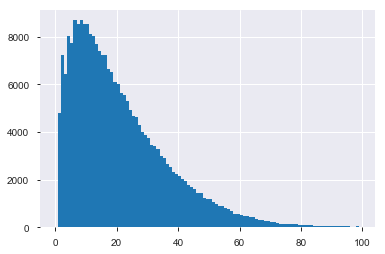

In [53]:
plt.hist(y_train,bins=range(0,100))

In [27]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.1, n_estimators=1500, subsample=0.8, colsample_bytree=0.75, max_depth=1, gamma = 0.6000000000000001, 
                   min_child_weight=2, objective="reg:linear", reg_alpha=0.1, reg_lambda=0.5  )
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.510622065292
CPU times: user 2min 37s, sys: 416 ms, total: 2min 38s
Wall time: 2min 38s


In [ ]:
%%time
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, max_depth =10)
model1.fit(train[col], np.log1p(train['visitors'].values))
preds1 = model1.predict(train[col])
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))

In [28]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, colsample_bytree=0.8, max_depth =10)
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.438197429237
CPU times: user 4min 1s, sys: 651 ms, total: 4min 2s
Wall time: 4min 2s


In [ ]:
# To do : Hyper parametres


In [ ]:
%%time
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model2.fit(train[col], np.log1p(train['visitors'].values))
preds2 = model2.predict(train[col])
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))

In [ ]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('data/*.csv.zip')}